# Machine Learning Analysis

## Import modules and clean data

In [1]:
# run the data story to get data wrangling and data story variables
%run ./data_story.ipynb

E-Bikes dropped: 338834
Original scooter entries: 6510117
NA rows dropped: 130
Out of Bounds entries dropped: 52981
Before removing outliers:


<Figure size 1000x500 with 2 Axes>

Negative duration dropped: 1028
Over 12.0 hours dropped: 262
Negative or 0 distance dropped: 505391
Distance > 49.9999845312 mi dropped: 965
After removing outliers:


<Figure size 1000x500 with 2 Axes>

Total entries remaining: 5949360
Percent removed: 8.61362399477613%
Column Data types:
Device ID                           object
Vehicle Type                      category
Trip Duration                      float64
Trip Distance                      float64
Start Time                  datetime64[ns]
End Time                    datetime64[ns]
Modified Date               datetime64[ns]
Month                                 int8
Hour                                  int8
Day of Week                           int8
Council District (Start)           float64
Council District (End)             float64
Year                                 int16
Census Tract Start                  object
Census Tract End                    object
dtype: object


<Figure size 1000x500 with 2 Axes>

<Figure size 640x480 with 1 Axes>

Number of Census Tract Starts: 256
Number of Census Tract Ends: 257
Number of unique Census Tracts in the data: 271


<Figure size 640x480 with 1 Axes>

<Figure size 1500x1500 with 2 Axes>

<Figure size 1500x1500 with 2 Axes>

<Figure size 640x480 with 1 Axes>

Top 4 starting location counts by day:


<Figure size 1000x500 with 4 Axes>

Top 4 ending location counts by day:


<Figure size 1000x500 with 4 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 1500x1500 with 2 Axes>

<Figure size 1500x1500 with 2 Axes>

<Figure size 1500x1500 with 2 Axes>

<Figure size 1500x1500 with 2 Axes>

<Figure size 1500x1500 with 2 Axes>

In [2]:
# import modules
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import seaborn as sns
import datetime as dt
from sklearn.metrics import r2_score

## Prepare data for prediction

The function below was created to generate the number of rides in a census tract per hour.  Then the date columns can be used as features, and the number of rides as target.

In [3]:
# create a row for every hour
def ct_by_hour(df, census_tract, sample='H', end=False):
    '''Returns dataframe with the number of rides per hour
    df: DataFrame--the source DataFrame (i.e. scooters)
    census_tract: String--the census tract number
    sample: String--the desired sample rate (see pandas.DataFrame.resample documentation)
    end: boolean--If true, use census tract end for resampling'''
    
    if end:
        ct_df = pd.DataFrame(df[df['Census Tract End']==census_tract])
    else:
        ct_df = pd.DataFrame(df[df['Census Tract Start']==census_tract])
    
    # add a n column to sample
    ct_df['n'] = 1
    
    # resample at sample rate.  Use mean for distance/duration.  Also use mean to preserve datetime related values.
    # Use sum for n
    ct_df = ct_df.set_index('Start Time').resample(sample).agg({'Trip Duration': np.mean, 
                                                               'Trip Distance': np.mean,
                                                               'Month': np.mean,
                                                               'Day of Week': np.mean,
                                                               'Hour': np.mean,
                                                               'Year': np.mean,
                                                               'n': np.sum})
    
    
    # drop nas
    ct_df = ct_df.dropna()
    
    # Add day of month
    ct_df['Day of Year'] = ct_df.index.dayofyear
    
    # Return date and time columns.  Don't use duration and distance, as they would make better targets
    return ct_df[['Year', 'Day of Year', 'Day of Week', 'Hour', 'n']]


## Linear and Ridge Regression

In [4]:
def run_regression(regressor, census_tract, source_df=scooters):
    '''Runs desired regression on the specified census tract. Plots results and prints score
    Classifier: desired sklearn classifier
    census_tract: string--census tract number
    source_df: DataFrame--source dataframe, default is scooters'''
    
    # Create features and target
    df = ct_by_hour(source_df, census_tract)
    

    X = df[['Year', 'Day of Year', 'Day of Week', 'Hour']]
    y = df['n']

    # Split into test and training data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
    

    # Fit classifier to training data
    regressor.fit(X_train, y_train)

    # Predict on test data
    y_pred_reg = regressor.predict(X_test)

    plt.figure(figsize=(10, 5))
    
    plt.scatter(y_test, y_pred_reg)
    plt.xlabel('y_test')
    plt.ylabel('y_pred')
    plt.plot([0, 750], [0, 750], '--k')

    plt.tight_layout()
    plt.show()
    plt.close()

    print(f'Confidence score of {r2_score(y_test, y_pred_reg)} \n')
    
    return regressor, X, y

In [167]:
def mape_error(y_actual, y_pred):
    mape = np.sum(abs(y_actual - y_pred) / abs(y_actual)) / len(y_actual)
    return mape

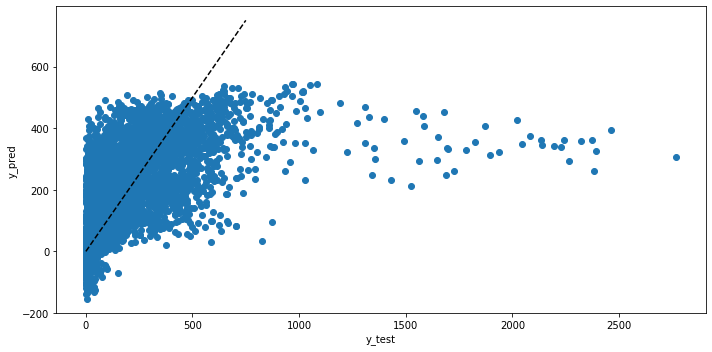

Confidence score of 0.27801549939689374 



,0
Year,219.320397
Day of Year,0.413987
Day of Week,17.178929
Hour,15.277765


In [5]:
# Run a linear regression on the most popular census tract
linreg, linreg_X, linreg_y= run_regression(LinearRegression(), '48453001100');

# print the coefficients 
pd.DataFrame(linreg.coef_, linreg_X.columns)

Running the Linear Regression as in the code above produces a dismal r2 score of .28.

### One Hot Encoding

Use a One Hot Encoder to expand the date features into categorical data.  The function below creates a One Hot Encoder to split the categories into Year, Day of Year, Day of Week, and Hour.

In [168]:
def expanded_linreg(ct):
    # Create features and target
    df = ct_by_hour(scooters, ct)
    X = df[['Year', 'Day of Year', 'Day of Week', 'Hour']]
    y = df['n']

    # initiate a OneHotEncoder to transform X into categorical data.
    ohe = OneHotEncoder(categories='auto')

    # fit transform the ohe to create a categorical X
    X_vectorized = ohe.fit_transform(X).toarray()

    # Split into test and training data
    X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=0.4, random_state=42)

    # Fit classifier to training data
    # Using Linear regression 
    reg = LinearRegression()
    reg.fit(X_train, y_train)

    # Predict on test data
    y_pred = reg.predict(X_test)
    
    plt.subplot(1,2,1)
    plt.scatter(y_test, y_pred)
    plt.xlabel('y_test')
    plt.ylabel('y_pred')
    plt.plot([0, max(y_pred)], [0, max(y_pred)], '--k')
    plt.title(str(reg))
    
    # revert the x_test back to dates to plot
    X_test_dates = pd.DataFrame(ohe.inverse_transform(X_test), columns=['year', 'day of year', 'day of week', 'hour'])
    X_test_dates['month'] = pd.to_datetime(X_test_dates['day of year'], format='%j').dt.strftime('%m')
    X_test_dates['day'] = pd.to_datetime(X_test_dates['day of year'], format='%j').dt.strftime('%d')
    X_test_dates = pd.to_datetime(X_test_dates[['year', 'month', 'day', 'hour']])
    
    
    plt.subplot(1,2,2)
    plt.scatter(X_test_dates, y_pred, color='b', alpha=0.5, label='y predicted')
    plt.scatter(X_test_dates, y_test, color='r', alpha=0.5, label='y test')
    plt.xticks(rotation=90)
    plt.legend()
    plt.xlim(dt.date(2019, 6, 1), dt.date(2019, 6, 14))
    plt.xlabel('Date')
    plt.ylabel('Number of Rides')
    
    
    plt.show()
    plt.close()

    print(f'Confidence score for categorical X with Linear Regression: {r2_score(y_test, y_pred)}')
    print(f'MAPE: {mape_error(y_test, y_pred)}')
    
    coeff = pd.DataFrame(reg.coef_, 
                         ohe.get_feature_names(['year', 'Day of Year', 'day of week', 'hour']), 
                         columns=['Coefficient'])
    return reg, coeff

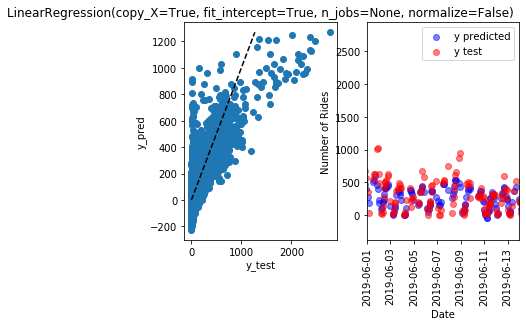

Confidence score for categorical X with Linear Regression: 0.6178287928454116
MAPE: 5.867802374393699
                  Coefficient
year_2018.0      4.570367e+14
year_2019.0      4.570367e+14
Day of Year_1   -4.363017e+14
Day of Year_2   -4.363017e+14
Day of Year_3   -4.363017e+14
Day of Year_4   -4.363017e+14
Day of Year_5   -4.363017e+14
Day of Year_6   -4.363017e+14
Day of Year_7   -4.363017e+14
Day of Year_8   -4.363017e+14
Day of Year_9   -4.363017e+14
Day of Year_10  -4.363017e+14
Day of Year_11  -4.363017e+14
Day of Year_12  -4.363017e+14
Day of Year_13  -4.363017e+14
Day of Year_14  -4.363017e+14
Day of Year_15  -4.363017e+14
Day of Year_16  -4.363017e+14
Day of Year_17  -4.363017e+14
Day of Year_18  -4.363017e+14
Day of Year_19  -4.363017e+14
Day of Year_20  -4.363017e+14
Day of Year_21  -4.363017e+14
Day of Year_22  -4.363017e+14
Day of Year_23  -4.363017e+14
Day of Year_24  -4.363017e+14
Day of Year_25  -4.363017e+14
Day of Year_26  -4.363017e+14
Day of Year_27  -4.363017e+1

In [169]:
# Run the classifier on 3 census tracts
reg, coeff = expanded_linreg('48453001100')
# expanded_linreg('48453000601')
# expanded_linreg('48453000603')

print(coeff)

Expanding the features using One Hot Encoding doubled the R2 score.  However, the coefficients of the linear regression yeilded very similar coefficients across each category.

### Ridge Regression
While similar coefficients is not necessarily a problem for the model, using Ridge regularization may improve results.  I try this below:

In [8]:
def mean_squared_error(truth, predicted):
    m = truth.shape[0]
    mse = (np.sum((predicted - truth) ** 2)) / (2 * m)
    return mse


# create a dataframe 
def make_xy(n_cts):
    # initialize dataframe of top cts
    top_ct_df = pd.DataFrame(columns=['Year', 'Month', 'Day of Month', 'Day of Week', 'Hour', 'n', 'Census Tract'])
    
    for ct in census_starts.head(n_cts).index.values:
        ct_df = ct_by_hour(scooters, ct)
        ct_df['Census Tract'] = ct
        top_ct_df = top_ct_df.append(ct_df, sort=False)
    
    # pivot dataframe so that each ct is a column
    y = top_ct_df.pivot(columns='Census Tract', values='n')

    # fill NAs with 0
    y = y.fillna(0)

    # make x from the date data
    X = pd.DataFrame(index=y.index)
    X['Year'] = X.index.year
    X['Day of Year'] = X.index.dayofyear
    X['Day of Week'] = X.index.dayofweek
    X['Hour'] = X.index.hour
    
    return X, y

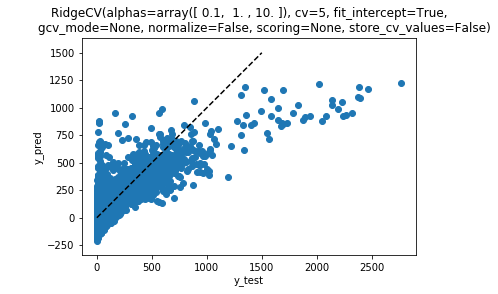

Average confidence score for categorical X with Ridge regression and 5-fold cross validation: 0.6160660109405548
MSE: Census Tract
48453001100    12035.299461
dtype: float64
MAPE: Census Tract
48453001100    5.725695
dtype: float64


,year_2018,year_2019,day of year_1,day of year_2,day of year_3,day of year_4,day of year_5,day of year_6,day of year_7,day of year_8,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
Census Tract,,,,,,,,,,,,,,,,,,,,,
48453001100,-104.291295,104.291295,-127.714707,-155.567778,-119.451518,-90.889573,-173.256311,-209.836076,-175.664098,-105.158952,...,113.967896,141.783253,186.705746,213.75957,177.664584,150.853576,117.386602,69.824494,29.614394,14.267718


In [172]:
X, y = make_xy(1)

ohe = OneHotEncoder(categories='auto')

# fit transform the ohe to create a categorical X
X_vectorized = ohe.fit_transform(X).toarray()

    # Split into test and training data
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=0.4, random_state=42)

    # Fit classifier to training data
reg = RidgeCV(cv=5)
reg.fit(X_train, y_train)

    # Predict on test data
y_pred = reg.predict(X_test)

plt.scatter(y_test, y_pred)
plt.xlabel('y_test')
plt.ylabel('y_pred')
plt.plot([0, 1500], [0, 1500], '--k')
plt.title(str(reg))
plt.axis('equal')
plt.show()
plt.close()

print(f'Average confidence score for categorical X with Ridge regression and 5-fold cross validation: {r2_score(y_test, y_pred)}')
print(f'MSE: {mean_squared_error(y_test, y_pred)}')
print(f'MAPE: {mape_error(y_test, y_pred)}')
    
pd.DataFrame(reg.coef_, columns=ohe.get_feature_names(['year', 'day of year', 'day of week', 'hour']), index=y.columns)

The r2 score for ridge regression was very similar to the results of the linear regression.  Both were about 0.62.  Try improving by tuning the alpha hyperparameter

### Hyperparameter Tuning

In [173]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge # Use 'plain' ridge because CV will be completed by gridsearchcv
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import Lasso

# Make a list of alpha values to try
params_ridge = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

#Ridge
ridge = Ridge()
ridge_tune = GridSearchCV(ridge, params_ridge, cv=5)
ridge_tune.fit(X_train, y_train)
y_pred_tune = ridge_tune.predict(X_test)
print(ridge_tune.best_estimator_)
print(ridge_tune.best_params_)
print(ridge_tune.best_score_)
print(f'R2 prediction score {r2_score(y_test, y_pred_tune)}')
print(f'MAPE: {mape_error(y_test, y_pred_tune)}')


# improve the ridge estimator.  Since 1 was the best alpha, try some more values near one
params_ridge_2 = {'alpha': [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.5, 2, 5]}
ridge_tune_2 = GridSearchCV(ridge, params_ridge_2, cv=5)
ridge_tune_2.fit(X_train, y_train)
y_pred_tune_2 = ridge_tune_2.predict(X_test)
print(ridge_tune_2.best_estimator_)
print(ridge_tune_2.best_params_)
print(ridge_tune_2.best_score_)
print(f'R2 prediction score {r2_score(y_test, y_pred_tune_2)}')
print(f'MAPE: {mape_error(y_test, y_pred_tune_2)}')

# Try grid searching on linear regression
params_linreg = {'fit_intercept': [True, False], 'normalize': [True, False]}
linreg_tune = GridSearchCV(linreg, params_linreg, cv=5)
linreg_tune.fit(X_train, y_train)
y_pred_linreg_tune = linreg_tune.predict(X_test)
print(linreg_tune.best_estimator_)
print(linreg_tune.best_score_)
print(f'linreg_tune R2 prediction score {r2_score(y_test, y_pred_linreg_tune)}')
print(f'MAPE: {mape_error(y_test, y_pred_linreg_tune)}')

# # Try grid searching on a bayesian ridge regression
# params_b_ridge = {
#     'alpha_1': [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1],
#     'alpha_2': [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1],
#     'lambda_1': [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1],
#     'lambda_2': [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1],
# }
# b_ridge = BayesianRidge()
# b_ridge_tune = GridSearchCV(b_ridge, params_b_ridge, cv=5)
# b_ridge_tune.fit(X_train, y_train)
# y_pred_b_ridge_tune = b_ridge_tune.predict(X_test)
# print(b_ridge_tune.best_estimator_)
# print(b_ridge_tune.best_score_)
# print(f'Bayesian Ridge R2 score: {r2_score(y_test, y_pred_b_ridge_tune)}')

# Try a Lasso Regression --actually don't, it does not converge.
# lasso = Lasso() #max_iter=10000 did not converge
# lasso_tune = GridSearchCV(lasso, params_ridge, cv=5) # start with the ridge params
# lasso_tune.fit(X_train, y_train)
# y_pred_tune_lasso = lasso_tune.predict(X_test)
# print(lasso_tune.best_estimator_)
# print(lasso_tune.best_score_)
# print(r2_score(y_test, y_pred_tune_lasso))


Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)
{'alpha': 1}
0.6023875428311409
R2 prediction score 0.6160660109405548
MAPE: Census Tract
48453001100    5.725695
dtype: float64
Ridge(alpha=0.7, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)
{'alpha': 0.7}
0.6025103932390828
R2 prediction score 0.6169904128973964
MAPE: Census Tract
48453001100    5.760208
dtype: float64
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
0.6012792375611025
linreg_tune R2 prediction score 0.6178697926684047
MAPE: Census Tract
48453001100    5.869271
dtype: float64


In [12]:
# get dates out of X train to plot
X_test_dates = pd.DataFrame(ohe.inverse_transform(X_test), columns=['year', 'day of year', 'day of week', 'hour'])

X_test_dates['month'] = pd.to_datetime(X_test_dates['day of year'], format='%j').dt.strftime('%m')
X_test_dates['day'] = pd.to_datetime(X_test_dates['day of year'], format='%j').dt.strftime('%d')
X_test_dates = pd.to_datetime(X_test_dates[['year', 'month', 'day', 'hour']])

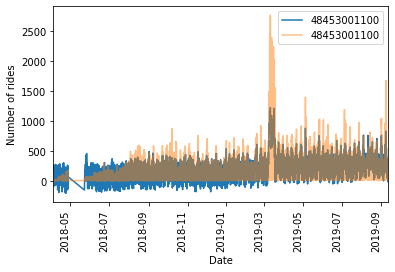

In [13]:
# Create a DataFrame of predictions
predictions_df = pd.DataFrame(y_pred, columns=y.columns, index=X_test_dates)

# Plot date vs number of rides predicted and actual rides
for i, ct in enumerate(predictions_df.columns):
    predictions_df.plot(y=ct)
    y_test[ct].plot(alpha=0.5)
    plt.xticks(rotation=90)
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Number of rides')
    plt.show()

In [14]:
# # create an area plot of the predicted use

# # transform predictions into percent of total for these top cts 
# percent_pred_df = pd.DataFrame()
# for column in predictions_df.columns:
#     percent_pred_df[column] = predictions_df[column] / predictions_df.sum(axis=1)
    
    
# # Transform test data into percent of total for these top cts
# percent_test_df = pd.DataFrame()
# for column in y_test.columns:
#     percent_test_df[column] = y_test[column] / y_test.sum(axis=1)
    
# # Plot predicted percentages and actual percentages

# percent_pred_df.clip(lower=0).plot.area(stacked=True, figsize=(10,10))
# plt.ylim(bottom=0, top=1)
# plt.xlim(dt.date(2018, 7, 1), dt.date(2018, 8, 1))
# plt.show()
# plt.close()
# # percent_pred_df
# # plt.stackplot(x=percent_pred_df.index.values, y=percent_pred_df.values.transpose())

## Batch Gradient Descent

### Define Batch Gradient Descent Functions

In [15]:
def mean_squared_error(truth, predicted):
    m = truth.shape[0]
    mse = (np.sum((predicted - truth) ** 2)) / (2 * m)
    return mse

def batch_gradient_descent(X, y, learn_rate, n_iter):
    
    weights = np.zeros(X.shape[1])
    
    history = []
    m = len(y)
    
    predict = lambda x: np.dot(x, weights)
    derivative = lambda loss: (X.T.dot(loss)) / m
    
    for i in range(n_iter):
        hypothesis = predict(X)
        loss = hypothesis - y
        weights = weights - learn_rate * derivative(loss)
        
        
        if i % 50 == 0:
            history.append(mean_squared_error(X.dot(weights), y))
    
    return predict, history

### Create data set and predictions

In [174]:
# Make Xy for the top census tract
X, y = make_xy(1)

# One Hot encode X
ohe = OneHotEncoder(categories='auto') 
X_vectorized = ohe.fit_transform(X).toarray()

# convert y to series by extracting census tract data
y = y.iloc[:,0]

X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=0.4)

In [ ]:
# Run the predictor
predictor, history = batch_gradient_descent(X_train, y_train, 0.05, 50000)

In [ ]:
# Evaluate the predictor
y_pred = predictor(X_test)
print(f'learning rate: 0.05, n_iterations: 50,000, mean squared error: {mean_squared_error(y_test, y_pred)}')
print(f'r squared score: {r2_score(y_test, y_pred)}')
print(f'MAPE: {mape_error(y_test, y_pred)}')

plt.plot(history)
plt.xlabel('iteration')
plt.ylabel('error')
plt.show()

This r2 score is slightly lower than the ridge regression, but it may be able to be improved by hyperparameter tuning.

### Tune Hyperparameters

In [ ]:
# define a function to test hyperparameters to find best convergence of the model:
import time

def test(X, y, lrates, niterations):
    record = []
    
    for niter in niterations:
        for lrate in lrates:
            start = time.time()
            weights, records = batch_gradient_descent(X, y, lrate, niter)
            delta = time.time() - start
            record.append(dict(lrate=lrate, niter=niter, w=weights, history=records, time=delta))
    
    return record



In [ ]:
# Define hyperparameter values to try
learn_rates = [10, 1, 0.5, 0.1, 0.01, 0.001, 0.0001]
n_iterations = [10000, 20000, 50000]

# Test these values
records = test(X_train, y_train, learn_rates, n_iterations)

In [ ]:
# Plot results
figure, plots = plt.subplots(len(learn_rates), len(n_iterations), figsize=(10,40))
figure.tight_layout()
plots = plots.flatten()
for i, record in enumerate(records):
    time = "{0:.4f}".format(record['time'])
    label = 'lr: {0}, ni: {1}, t: {2}'.format(record["lrate"], record["niter"], time)
    plots[i].plot(record['history'], label=label)
    plots[i].legend(loc='upper right')


In [ ]:
import tabulate
time_sorted_records = sorted(records, key=lambda k: k['time']) 
tab_data = time_sorted_records.copy()
for r in tab_data:
    r['cost'] = r['history'][-1]
    del r['history']
    del r['w']
print(tabulate.tabulate(tab_data, headers={'lrate': 'lrate', 'niter': 'niter', 'time': 'elapsed time', 'cost': 'cost'}))

The model converges fastests at 10,000 iterations with a learning rate of 1. So we'll use these parameters to run the model one more time.

In [23]:
predictor_tuned, history_tuned = batch_gradient_descent(X_train, y_train, 1, 10000)

In [ ]:
# Evaluate the predictor
y_pred_tuned = predictor_tuned(X_test)
print(f'learning rate: 1, n_iterations: 10,000, mean squared error: {mean_squared_error(y_test, y_pred_tuned)}')
print(f'r squared score: {r2_score(y_test, y_pred_tuned)}')
print(f'MAPE: {mape_error(y_test, y_pred_tuned)}')

plt.plot(history_tuned)
plt.xlabel('iteration')
plt.ylabel('error')
plt.show()

The r2 score was only slightly improved by tuning, but the 10,000 iterations will run faster than 50,000.

## t-SNE visualization

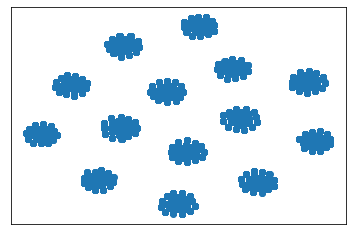

In [25]:
from sklearn.manifold import TSNE

# initialize a TSNE classifer
tsne = TSNE()

# using the one hot encoded x from the previous section
x_tsne = tsne.fit_transform(X_vectorized)

# Plot the result
plt.scatter(x_tsne[:, 0], x_tsne[:, 1])
plt.xticks([])
plt.yticks([])
plt.show()

In [26]:
X_tsne_train, X_tsne_test, y_tsne_train, y_tsne_test = train_test_split(x_tsne, y, test_size=0.4)
linreg_tsne = LinearRegression()

linreg_tsne.fit(X_tsne_train, y_tsne_train)

y_tsne_pred = linreg_tsne.predict(X_tsne_test)

print(f'TSNE R2 score: {r2_score(y_pca_test,y_pca_pred)}')

NameError: name 'y_pca_test' is not defined

## PCA transformation and visualization

In [ ]:
from sklearn.decomposition import PCA

# initialize PCA object
pca = PCA(n_components=30)

X_pca = pca.fit_transform(X_vectorized)

In [ ]:
X_pca.shape

In [ ]:
plt.scatter(x=X_pca, y=y)
plt.show()

In [ ]:
X_pca_train, X_pca_test, y_pca_train, y_pca_test = train_test_split(X_pca, y, test_size=0.4)

linreg_pca = LinearRegression()

linreg_pca.fit(X_pca_train, y_pca_train)

y_pca_pred = linreg_pca.predict(X_pca_test)

print(f'PCA R2 score: {r2_score(y_pca_test,y_pca_pred)}')

Cite:
http://pavelbazin.com/post/linear-regression-hyperparameters/

@article{scikit-learn,
 title={Scikit-learn: Machine Learning in {P}ython},
 author={Pedregosa, F. and Varoquaux, G. and Gramfort, A. and Michel, V.
         and Thirion, B. and Grisel, O. and Blondel, M. and Prettenhofer, P.
         and Weiss, R. and Dubourg, V. and Vanderplas, J. and Passos, A. and
         Cournapeau, D. and Brucher, M. and Perrot, M. and Duchesnay, E.},
 journal={Journal of Machine Learning Research},
 volume={12},
 pages={2825--2830},
 year={2011}
}

Taylor SJ, Letham B. 2017. Forecasting at scale. PeerJ Preprints 5:e3190v2 https://doi.org/10.7287/peerj.preprints.3190v2

## Using Facebook Prophet

In [159]:
def prophesy(census_tract, df=scooters, sample_rate='H', forecast_periods=30, add_holidays=False, plot=True, plot_components=True, cross_validate=True):
    '''Use Facebook prophet on the specified census tract:
    df: source DataFrame
    census_tract:  string of census tract number
    sample_rate: rate at which to run the sample, defaults to "H" for hourly, can also be "D" for daily
    forecast_periods: number of periods to forecast after primary data
    add_holiday: default to false, can be dataframe that follows fbprophet holiday dataframe conventions
    plot: if True, plot the results
    plot_components: if True, plot the components'''
    
        #Plot the location of the census tract
    fig, (ax2) = plt.subplots()
    map_df.plot(color='0.9', edgecolor='0.0', ax=ax2)
    ax2.axis('off')
    ax2.set(title='Location of ' + census_tract)
    map_df[map_df['CTIDFP00'] == census_tract].plot(color='g', ax=ax2)
    bbox = (-97.919881, -97.589348, 30.139918,30.426626)
    plt.xlim(bbox[0], bbox[1])
    plt.ylim(bbox[2], bbox[3])
    plt.show()
    
    
    # Use ct by hour function to get hourly data for a census tract
    ct_x_by_hour = ct_by_hour(df,census_tract, sample=sample_rate)['n'].reset_index()
    ct_x_by_hour.columns = ['ds', 'y']

    # import facebook prophet
    from fbprophet import Prophet

    # Create a holidays dataframe that includes non-standard holidays (i.e. SXSW)
    sxsw = pd.DataFrame({
        'holiday': 'sxsw',
        'ds': pd.to_datetime(['2017-03-10', '2018-03-09', '2019-03-08']),
        'lower_window': 0,
        'upper_window': 9
    })
    
    if add_holidays is False:
        holidays= sxsw
    else:
        holidays = sxsw.concat(add_holidays)


    # instatiate prophet model, use mult seasonality because the magnitude of peaks/valleys increases
    fbp = Prophet(holidays=holidays, yearly_seasonality=True, seasonality_mode='multiplicative')

    # add standard US holidays
    fbp.add_country_holidays(country_name='US')

    # fit to dataframe
    fbp.fit(ct_x_by_hour)
    
    # create a dataframe for predicting
    future = fbp.make_future_dataframe(periods=forecast_periods, freq=sample_rate)

    # create a forecast
    forecast = fbp.predict(future)

    from fbprophet.plot import add_changepoints_to_plot

    # Plot the results and the components
    if plot is True:
        fig1 = fbp.plot(forecast)
        a = add_changepoints_to_plot(fig1.gca(), fbp_1100, forecast)
    
    if plot_components is True:
        fig2 = fbp.plot_components(forecast)
        
    if cross_validate is True:
        
        # Run cross validation
        from fbprophet.diagnostics import cross_validation
        df_cv = cross_validation(fbp, initial='500 days', horizon='7 days')
        performance = performance_metrics(df_cv)
        
        # plot
        fig3 = plot_cross_validation_metric(df_cv, metric='mape')
        
        print(f'{census_tract} r2 score: {r2_score(df_cv.y, df_cv.yhat)}')
        return fbp, performance, df_cv
    else:
        return fbp

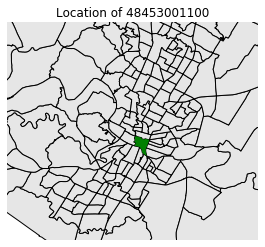

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 6 forecasts with cutoffs between 2019-08-17 12:00:00 and 2019-09-04 00:00:00


48453001100 r2 score: 0.2890065970561313


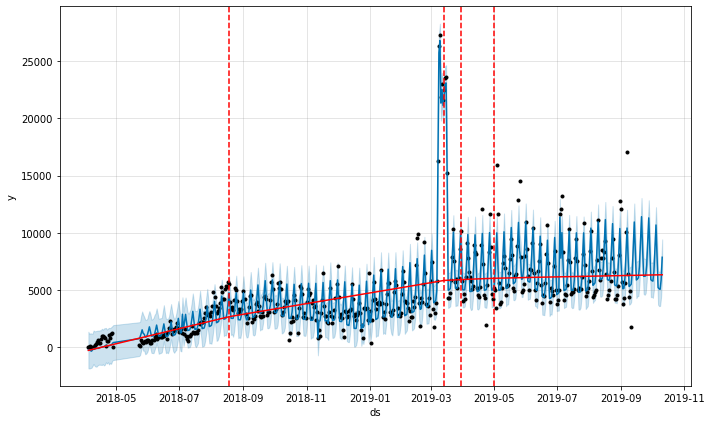

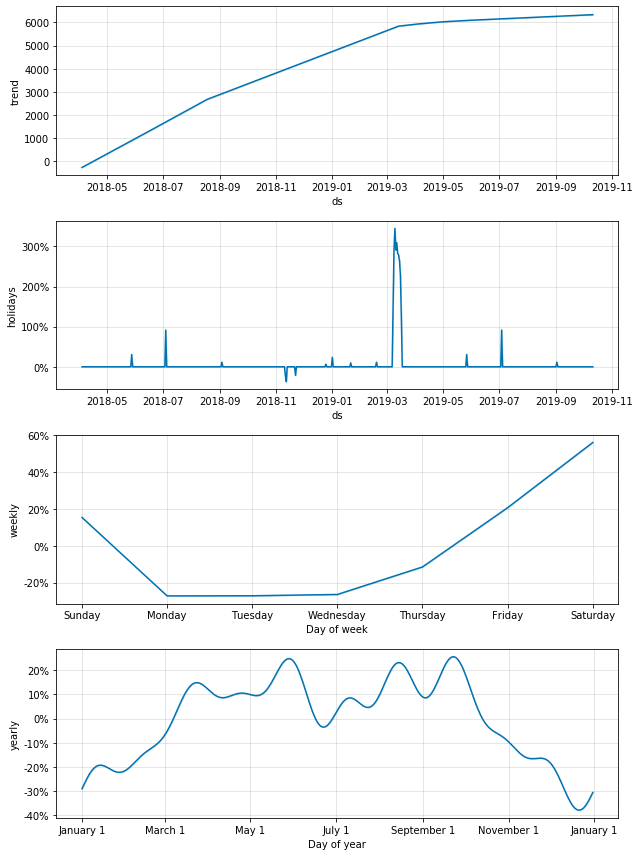

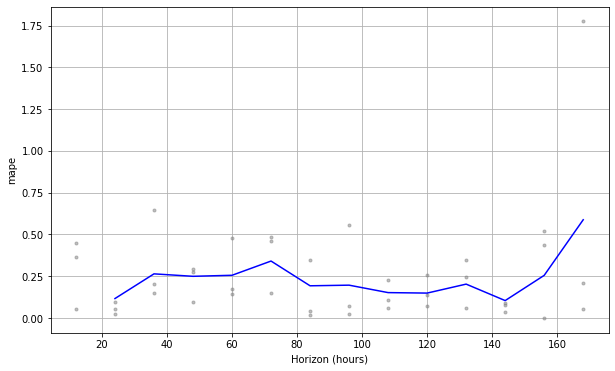

In [160]:
fbp_1100, performance_1100, df_cv_1100 = prophesy('48453001100', sample_rate='D')

In [170]:
mape_error(df_cv_1100.y, df_cv_1100.yhat)

0.24695206019865865

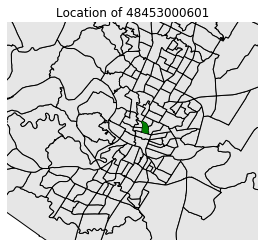

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 5 forecasts with cutoffs between 2019-08-21 00:00:00 and 2019-09-04 00:00:00


48453000601 r2 score: 0.04085007761200343


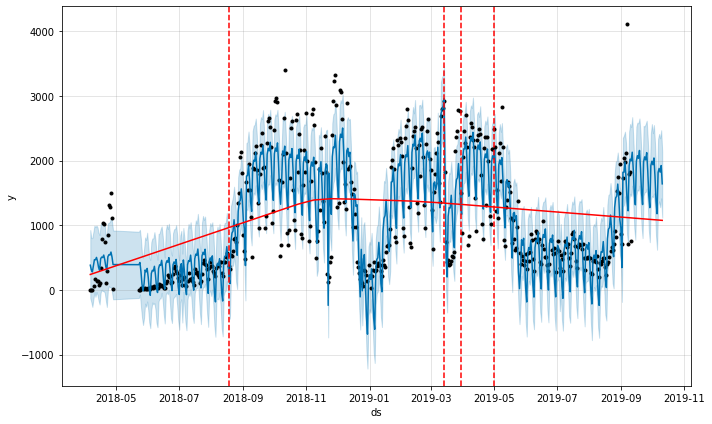

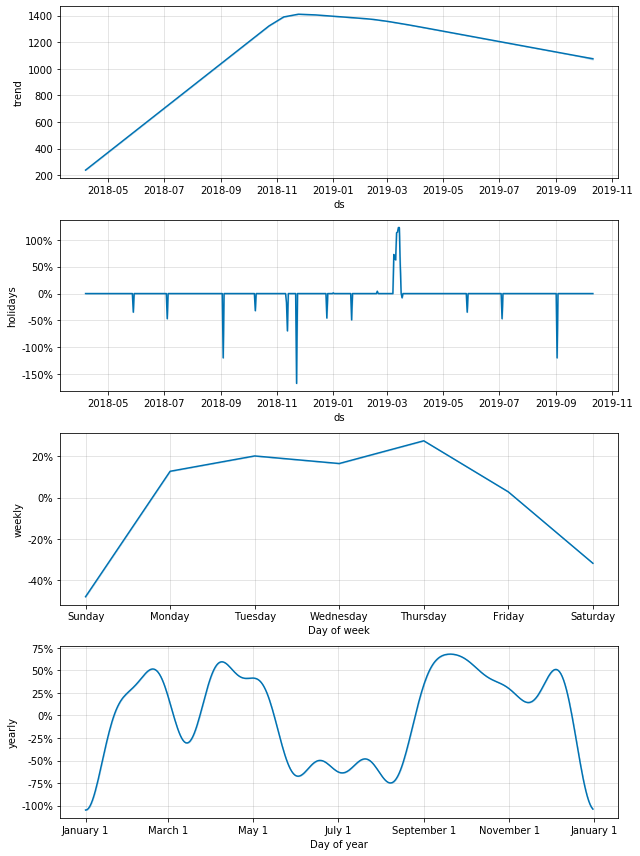

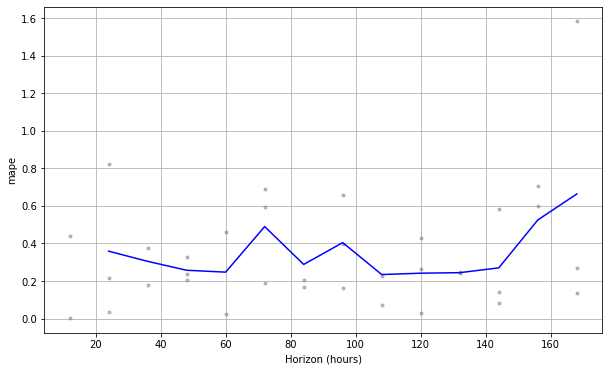

In [161]:
fbp_0601, performance_0601, df_cv_0601 = prophesy('48453000601', sample_rate='D')

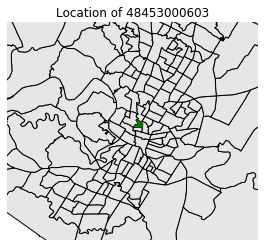

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 5 forecasts with cutoffs between 2019-08-21 00:00:00 and 2019-09-04 00:00:00


48453000603 r2 score: 0.3482429726404709


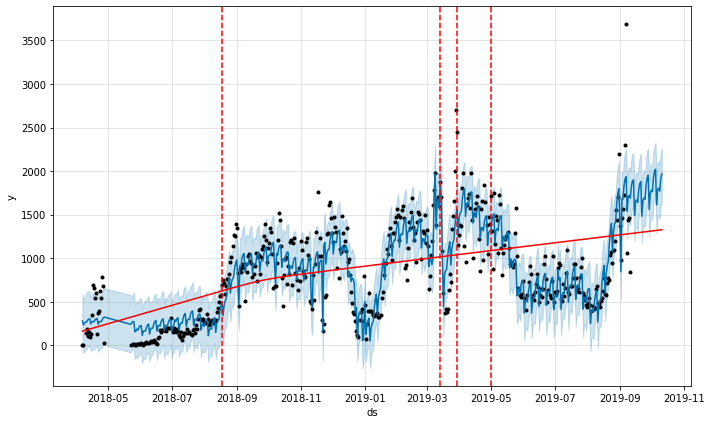

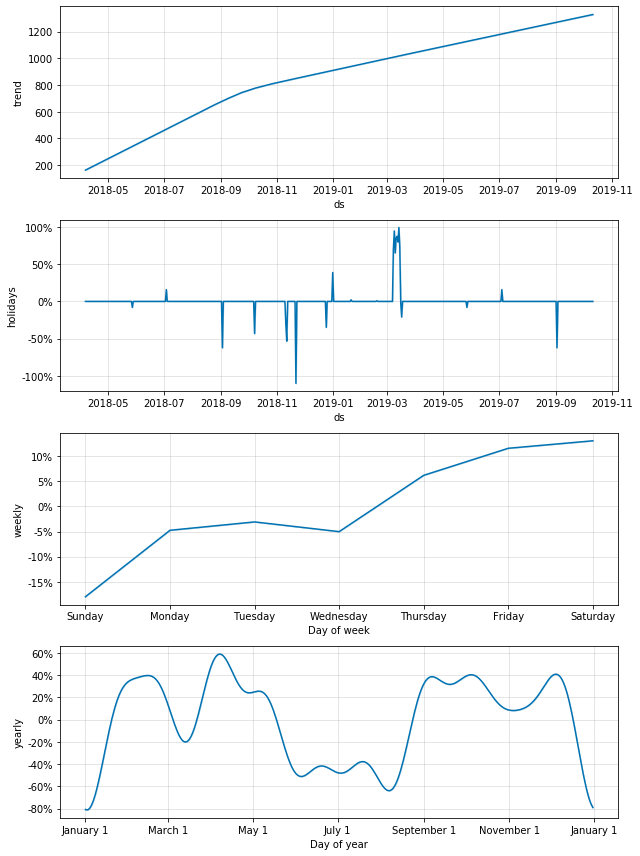

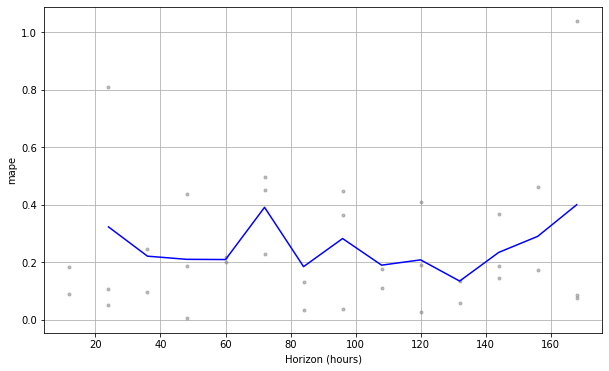

In [162]:
fbp_0603, performance_0603, df_cv_0603 = prophesy('48453000603', sample_rate='D')

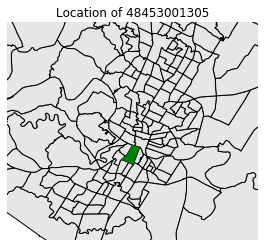

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 5 forecasts with cutoffs between 2019-08-21 00:00:00 and 2019-09-04 00:00:00


48453001305 r2 score: 0.22968826558733013


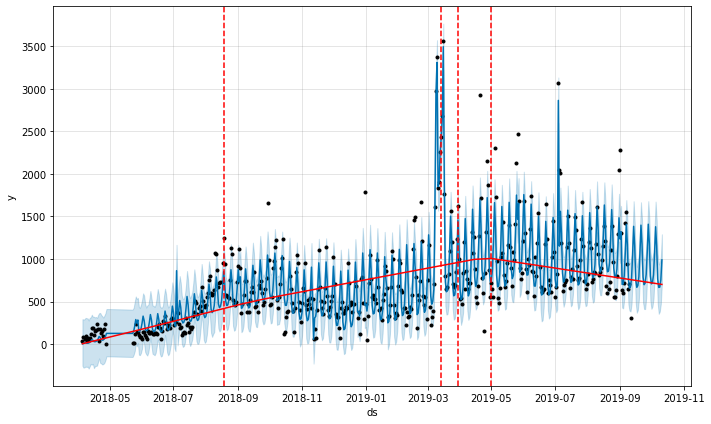

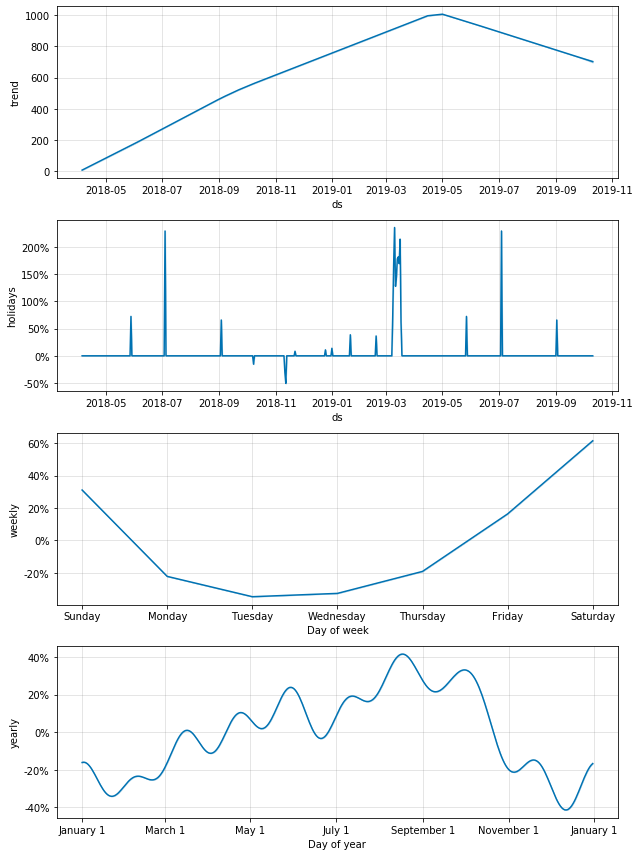

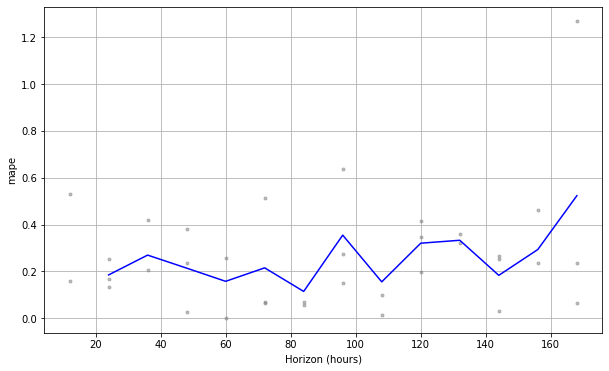

In [163]:
fbp_1305, performance_1305, df_cv_1305 = prophesy('48453001305', sample_rate='D')

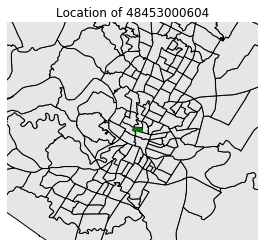

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 5 forecasts with cutoffs between 2019-08-21 00:00:00 and 2019-09-04 00:00:00


48453000604 r2 score: 0.3262133004839838


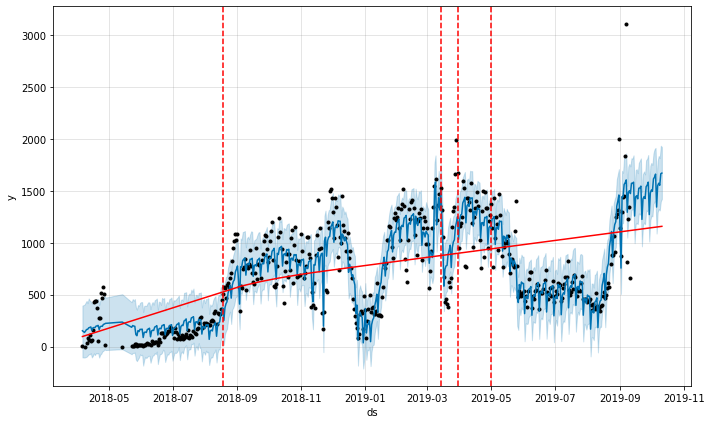

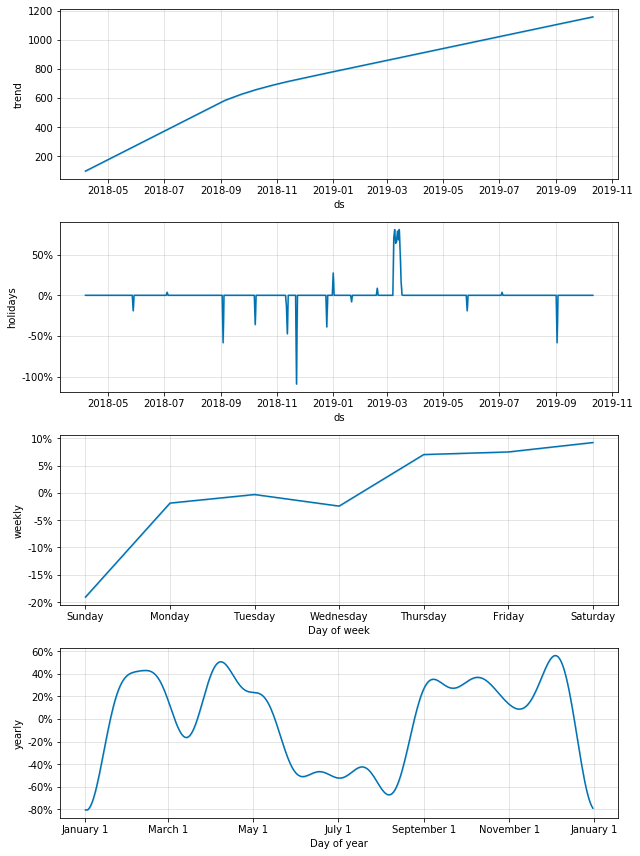

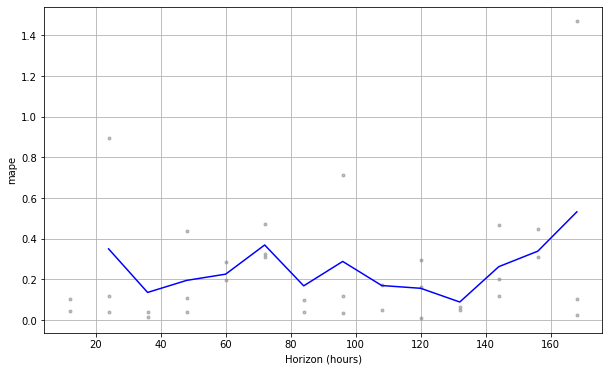

In [164]:
fbp_0604, performance_0604, df_cv_0604 = prophesy('48453000604', sample_rate='D')

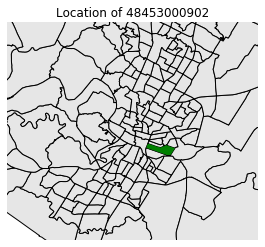

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 5 forecasts with cutoffs between 2019-08-21 00:00:00 and 2019-09-04 00:00:00


48453000902 r2 score: 0.7502091494497275


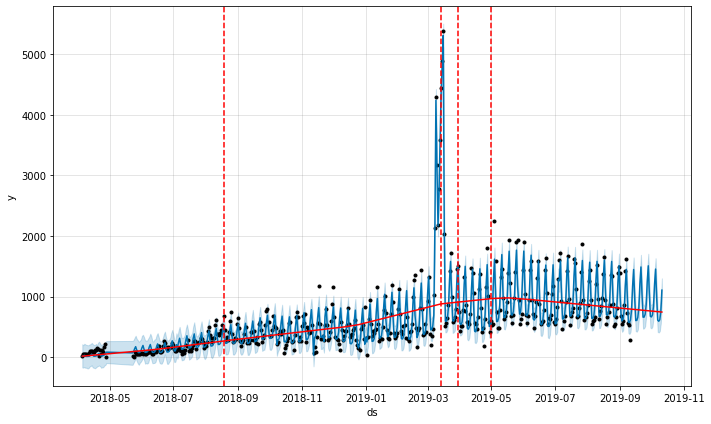

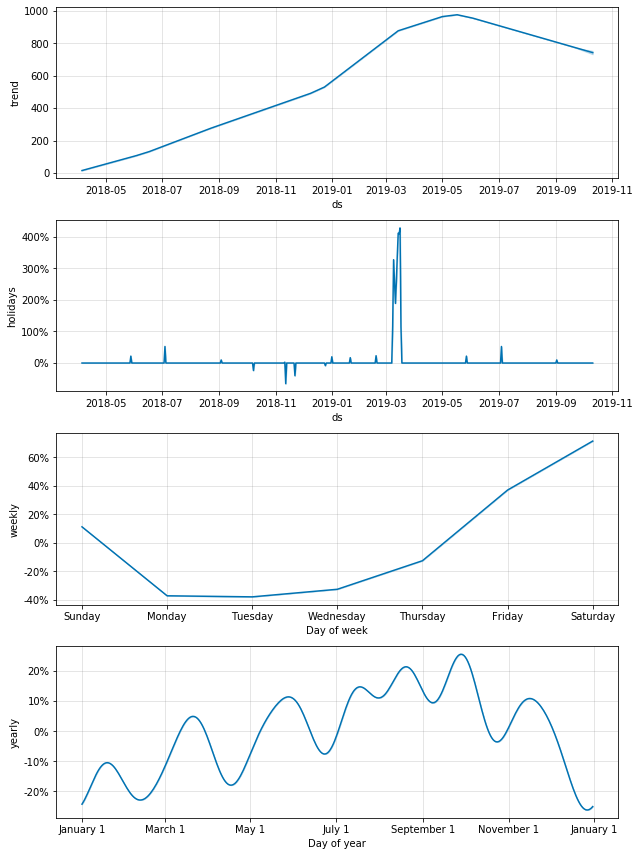

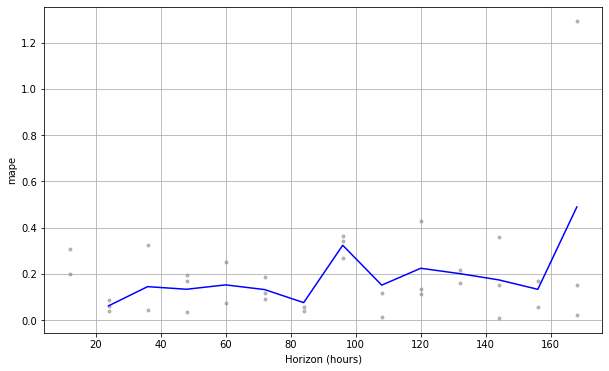

In [165]:
fbp_0902, performance_0902, df_cv_0902 = prophesy('48453000902', sample_rate='D')

In [166]:
r2_score(df_cv_0902['y'], df_cv_0902['yhat'] )

0.7502091494497275

In [171]:
mape_error(df_cv_0902['y'], df_cv_0902['yhat'] )

0.19019803095254437